# Unraveling Real Estate Ads

## Introduction

Data Sprints used one of its crawlers to mine data from multiple real estate ad portals and these data were obtained through web requests, with results in json format. The datacame unstructured and containing several problems, such as duplicate data, incomplete lines and discrepant data. The main nodes of the json received for analysis were:

* id, has a unique identifier for each of the lines.
* index, has a unique value on all lines:“realties”.
* score, is a crawler metric, but all lines have a“1”.*source, is a complex node that is composed of all the data obtained by the crawler.
* type, represents the category, but all lines contain“imovel”.Therefore, the first step was to remove the nodes that contained the same infor-mation on all lines, because they add nothing to the analysis to be performed.  

Thus, the removed nodes were:  (I)index,  (II)score and (III)type.   Leaving only the id and source nodes in json.

## Getting Started

Load the Real Estate Ads dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
import json

import random
import datetime
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from pandas_profiling import ProfileReport

from pandas.io.json import json_normalize #package for flattening json in pandas df

# Import seaborn for some visualizations
import seaborn as sns

#map visualizations
import folium
from folium import plugins

import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_colwidth', 50000)
lb_make = LabelEncoder()

In [2]:
# Load the Real Estate Ads dataset
try:
    data = pd.read_csv("dataset.csv")
    data.drop(['Unnamed: 0'], axis = 1, inplace = True)
    print("Real Estate Ads dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

C:\Users\felip\Anaconda3\envs\datasprints\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (10,14,27,35,49,50,51,52,53,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Real Estate Ads dataset has 149968 samples with 63 features each.


In [3]:
data.columns

Index(['error', 'uf', 'longitude', 'url', 'condominio', 'cidade_uf', 'default',
       'area_util', 'area_total', 'contato_imobiliaria', 'valor', 'isportal',
       'isparticular', 'nome_corretor', 'banheiro', 'tipo_negocio', 'quarto',
       'status', 'title', 'opcionais', 'latitude', 'descricao', 'lista_fotos',
       'garagem', 'iptu', 'data_inclusao', 'codigo', 'finalidade', 'geohash',
       'tipo_imovel', 'endereco', 'geometry.type', 'geometry.coordinates',
       'scraping.spider_name', 'scraping.padrao', 'cidade.short_name',
       'cidade.full_name', 'bairro.id', 'bairro.nome', 'zoneamento.id',
       'zoneamento.sigla', 'zoneamento.nome', 'anunciante.id',
       'anunciante.nome', 'area_construida', 'suite', 'area_terreno',
       'area_privativa', 'cep', 'numero_corretor', 'idade_imovel', 'edificio',
       'isconstrutora', 'area_comum', 'seguro_incendio', 'email_corretor',
       'nome_contato', 'numero_contato_imagem', 'complemento', 'terreno_fundo',
       'terreno_frente

To begin the exploratory treatment of the data, we will remove the columns that do not add information for our analysis, either because they have a very small amount of data or constant values in their lines.

In [4]:
data.drop(columns=['uf', 'cidade_uf', 'complemento', 'edificio', 'email_corretor', 'idade_imovel', 'isconstrutora', 'nome_contato', 'numero_contato_imagem', 'nome_corretor', 'numero_corretor', 'scraping.padrao', 'seguro_incendio', 'terreno_esquerda', 'terreno_frente', 'terreno_fundo', 'testada', 'contato_imobiliaria', 'cidade.short_name', 'geometry.type', 'geometry.coordinates', 'cidade.full_name', 'bairro.nome', 'zoneamento.sigla', 'zoneamento.nome', 'anunciante.nome', 'area_construida', 'area_terreno', 'area_privativa', 'area_comum', 'cep', 'codigo', 'status'], inplace=True)

In [5]:
data.columns

Index(['error', 'longitude', 'url', 'condominio', 'default', 'area_util',
       'area_total', 'valor', 'isportal', 'isparticular', 'banheiro',
       'tipo_negocio', 'quarto', 'title', 'opcionais', 'latitude', 'descricao',
       'lista_fotos', 'garagem', 'iptu', 'data_inclusao', 'finalidade',
       'geohash', 'tipo_imovel', 'endereco', 'scraping.spider_name',
       'bairro.id', 'zoneamento.id', 'anunciante.id', 'suite'],
      dtype='object')

Then we check the null fields that are present.

In [6]:
data.isnull().sum()

error                       0
longitude               30336
url                         0
condominio              40432
default                     0
area_util               28606
area_total              43776
valor                    1462
isportal                    0
isparticular                0
banheiro                38243
tipo_negocio                0
quarto                  13090
title                     110
opcionais                   0
latitude                30336
descricao                   0
lista_fotos              4461
garagem                 21169
iptu                    53726
data_inclusao               0
finalidade                  0
geohash                 30375
tipo_imovel                 0
endereco                30363
scraping.spider_name        0
bairro.id                1148
zoneamento.id           38027
anunciante.id            1591
suite                   54175
dtype: int64

To handle the missing data, we have two options. The first is to fill the missing data with statistical values ​​such as average, median, fashion, zeros and placeholders. Another option is to remove the lines that contain missing data. We see that in this case there would be approximately 50 thousand records left. As our goal is to find repeated data, outliers and perform a dimensionality reduction to understand the data, it is better to adopt the first option. First we will put zeros in the missing data and in the case of categorical columns we will place a placeholder. 
At this point, if there was more time it would be interesting to fill the missing data with data closer to reality, such as checking the average value for houses for someone and the average value among houses for sale, and applying this value to the missing data.

In [7]:
data.dropna()

,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,isparticular,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
8,[],-49.277923,http://www.redebee.com.br/imovel/apartamento-3-quartos-a-venda-agua-verde-curitiba/AP0590-OTI,380.00,['finalidade'],59.0,104.0,260000.0,False,False,...,2018-12-07 14:04:18,['Residencial'],6gkznwkvj5tr,['Apartamento'],"Água Verde, Curitiba",redebee_curitiba_pr,1640.0,qMJDsWQBpLEv0vTVF9WP,411cbb1b8d58afa3b9419a19714844ae,1.0
17,[],-49.289577,http://www.redebee.com.br/imovel/apartamento-residencial-a-venda-pinheirinho-curitiba/AP0309-TAN,338.89,['finalidade'],55.0,84.0,230000.0,False,False,...,2018-12-07 14:05:19,['Residencial'],6gkyykhqjs70,['Apartamento'],"Rua Lothário Boutin, 1",redebee_curitiba_pr,1719.0,kMJDsWQBpLEv0vTVF9WP,411cbb1b8d58afa3b9419a19714844ae,1.0
18,[],-49.254654,http://www.redebee.com.br/imovel/apartamento-residencial-a-venda-cabral-curitiba/AP0302-TAN,1166.99,['finalidade'],188.0,279.0,990000.0,False,False,...,2018-12-07 14:05:18,['Residencial'],6gkzrnvv76sj,['Apartamento'],"Rua Chichorro Júnior, 144",redebee_curitiba_pr,1651.0,a8JDsWQBpLEv0vTVF9WP,411cbb1b8d58afa3b9419a19714844ae,1.0
20,[],-49.245331,http://www.redebee.com.br/imovel/apartamento-residencial-a-venda-hugo-lange-curitiba/AP0609-MOT,400.00,['finalidade'],72.0,156.0,546000.0,False,False,...,2018-12-07 14:05:18,['Residencial'],6gkzrmh8hseg,['Apartamento'],"R. Fernandes de Barros, 1583",redebee_curitiba_pr,1656.0,wsJDsWQBpLEv0vTVF9WP,411cbb1b8d58afa3b9419a19714844ae,1.0
21,[],-49.304557,http://www.dimensaoimoveis.com.br/imovel/apartamento-com-02-dormitorios-semimobiliado-a-venda-novo-mundo-curitiba/AP0803-DII,252.00,['finalidade'],58.0,71.0,345000.0,False,False,...,2018-12-07 14:05:18,['Residencial'],6gkyyh990sck,['Apartamento'],"R. Laudelino Ferreira Lopes, Curitiba",dimensaoimoveis_sao_jose_dos_pinhais_pr,1676.0,LcJDsWQBpLEv0vTVF9WP,84601e3115afd420e3e098cf9231c6a0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149959,[],-49.275547,https://www.vivareal.com.br/imovel/casa-de-condominio-3-quartos-guaira-bairros-curitiba-com-garagem-105m2-aluguel-RS1730-id-1042911031/,100.00,['finalidade'],105.0,84.0,1730.0,True,False,...,2018-12-11 21:43:58,['Residencial'],6gkzn9wxkw9m,['Sobrado'],"R. Camilo Castelo Branco, 497",vivareal_curitiba,1652.0,CMJDsWQBpLEv0vTVF9WP,1f3c5da59df6fd9167752ff545774353,1.0
149960,[],-49.282461,https://www.vivareal.com.br/imovel/apartamento-3-quartos-agua-verde-bairros-curitiba-com-garagem-111m2-aluguel-RS1750-id-1042559249/,1146.00,['finalidade'],111.0,111.0,1750.0,True,False,...,2018-12-11 21:43:58,['Residencial'],6gkznt1s73ts,['Apartamento'],"R. Alcebíades Plaisant, 850",vivareal_curitiba,1640.0,Y8JDsWQBpLEv0vTVF9WP,1e8313a341f44bec7344e57b31fe858a,1.0
149961,[],-49.278497,https://www.vivareal.com.br/imovel/apartamento-3-quartos-agua-verde-bairros-curitiba-com-garagem-70m2-aluguel-RS1750-id-1042483748/,700.00,['finalidade'],70.0,70.0,1750.0,True,False,...,2018-12-11 21:43:58,['Residencial'],6gkzq8u7pf38,['Apartamento'],"Rua Desembargador Motta, 1600",vivareal_curitiba,1679.0,GcJDsWQBpLEv0vTVF9WP,1e8313a341f44bec7344e57b31fe858a,1.0
149962,[],-49.333080,https://www.vivareal.com.br/imovel/sobrado-3-quartos-santa-felicidade-bairros-curitiba-com-garagem-140m2-aluguel-RS1780-id-1039022690/,0.00,['finalidade'],140.0,140.0,1780.0,True,False,...,2018-12-11 21:43:58,['Residencial'],6gkzt3usrvvk,['Sobrado'],"R. Augusto Litz, 56",vivareal_curitiba,1692.0,KsJDsWQBpLEv0vTVF9WP,1e8313a341f44bec7344e57b31fe858a,1.0


In [8]:
nan_value = {'longitude': 0, 'condominio': 0, 'area_util': 0, 'area_total': 0, 'valor': 0, 'banheiro': 0, 'quarto': 0, 'title': 'No Title', 'latitude': 0, 'lista_fotos': '[]', 'garagem': 0, 'iptu': 0, 'geohash': 'No geohash', 'endereco': 'Sem endereço', 'bairro.id': 0, 'zoneamento.id': 'Sem id', 'anunciante.id': 'Sem id', 'suite': 0}
data.fillna(value=nan_value, inplace=True)

We will use the Label Encoder to label the catetegoric features.

##### error

In [9]:
for i in range(len(data)):
    if data.iloc[i].error == '[]':
        data.loc[i, 'error'] = '_'
    else:
        x = data.iloc[i].error.replace("'", '"')
        y = json.loads(x)
        w = json_normalize(y[0])
        data.loc[i, 'error'] = w.columns[0]

In [10]:
data.loc[:, 'error'] = lb_make.fit_transform(data.loc[:, 'error'])
data['error'].head()

0    1
1    1
2    1
3    1
4    1
Name: error, dtype: int32

##### longitude

In [3]:
longitude = data['longitude']

In [12]:
data.loc[:, 'longitude'] = lb_make.fit_transform(data.loc[:, 'longitude'])
data['longitude'].head()

0    14366
1    13792
2      992
3      904
4    26063
Name: longitude, dtype: int64

##### url

In [4]:
url = data['url']

In [16]:
data.loc[:, 'url'] = lb_make.fit_transform(data.loc[:, 'url'])
data['url'].head()

0    27746
1    29335
2    28173
3    28229
4    28687
Name: url, dtype: int32

##### default

In [17]:
data.loc[:, 'default'] = lb_make.fit_transform(data.loc[:, 'default'])
data['default'].head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int32

##### isportal

In [18]:
data.loc[:, 'isportal'] = lb_make.fit_transform(data.loc[:, 'isportal'])
data['isportal'].head()

0    0
1    0
2    0
3    0
4    0
Name: isportal, dtype: int64

##### isparticular

In [19]:
data.loc[:, 'isparticular'] = lb_make.fit_transform(data.loc[:, 'isparticular'])
data['isparticular'].head()

0    0
1    0
2    0
3    0
4    0
Name: isparticular, dtype: int64

##### tipo_negocio

In [20]:
data.loc[:, 'tipo_negocio'] = lb_make.fit_transform(data.loc[:, 'tipo_negocio'])
data['tipo_negocio'].head()

0    0
1    0
2    1
3    1
4    0
Name: tipo_negocio, dtype: int32

##### title

In [5]:
title = data['title']

In [22]:
data.loc[:, 'title'] = lb_make.fit_transform(data.loc[:, 'title'])
data['title'].head()

0    26192
1    85007
2    52214
3    52751
4    70387
Name: title, dtype: int32

##### opcionais

In [6]:
opcionais = data['opcionais']

In [24]:
data.loc[:, 'opcionais'] = lb_make.fit_transform(data.loc[:, 'opcionais'])
data['opcionais'].head()

0    70746
1    65493
2    70233
3    63677
4        0
Name: opcionais, dtype: int32

##### latitude

In [7]:
latitude = data['latitude']

In [26]:
data.loc[:, 'latitude'] = lb_make.fit_transform(data.loc[:, 'latitude'])
data['latitude'].head()

0    18587
1    21869
2    13325
3    26737
4     4271
Name: latitude, dtype: int64

##### descricao

In [8]:
descricao = data['descricao']

In [28]:
data.loc[:, 'descricao'] = lb_make.fit_transform(data.loc[:, 'descricao'])
data['descricao'].head()

0    99276
1    99289
2    60811
3    49907
4    88973
Name: descricao, dtype: int32

##### lista_fotos

In [9]:
lista_fotos = data['lista_fotos']

In [30]:
data.loc[:, 'lista_fotos'] = lb_make.fit_transform(data.loc[:, 'lista_fotos'])
data['lista_fotos'].head()

0    43717
1    48424
2    46358
3    46547
4    52894
Name: lista_fotos, dtype: int32

##### garagem

In [32]:
data.loc[:, 'garagem'] = lb_make.fit_transform(data.loc[:, 'garagem'])
data['garagem'].head()

0    1
1    1
2    1
3    2
4    0
Name: garagem, dtype: int64

##### iptu

In [33]:
data.loc[:, 'iptu'] = lb_make.fit_transform(data.loc[:, 'iptu'])
data['iptu'].head()

0    551
1    328
2      0
3      0
4    102
Name: iptu, dtype: int64

##### data_inclusao

For the inclusion date, we will ignore the inclusion times and focus on the days. Previously, we verified that the data were collected in three different days.

In [34]:
data['data_inclusao'] = pd.to_datetime(data['data_inclusao'])

In [35]:
datas = data['data_inclusao']

In [36]:
for i in range(len(data)):
    if data['data_inclusao'][i].date() == datetime.date(2018, 12, 7):
        data.loc[i, 'data_inclusao'] = '07/12/2018'
    elif data['data_inclusao'][i].date() == datetime.date(2018, 12, 8):
        data.loc[i, 'data_inclusao'] = '08/12/2018'
    elif data['data_inclusao'][i].date() == datetime.date(2018, 12, 11):
        data.loc[i, 'data_inclusao'] = '11/12/2018'

In [37]:
data.data_inclusao.value_counts()

11/12/2018    84215
07/12/2018    46316
08/12/2018    19437
Name: data_inclusao, dtype: int64

In [38]:
data.loc[:, 'data_inclusao'] = lb_make.fit_transform(data.loc[:, 'data_inclusao'])
data['data_inclusao'].head()

0    0
1    0
2    0
3    0
4    0
Name: data_inclusao, dtype: int32

##### finalidade

In [39]:
data.loc[:, 'finalidade'] = lb_make.fit_transform(data.loc[:, 'finalidade'])
data['finalidade'].head()

0    6
1    6
2    6
3    6
4    2
Name: finalidade, dtype: int32

##### geohash

In [40]:
data.loc[:, 'geohash'] = lb_make.fit_transform(data.loc[:, 'geohash'])
data['geohash'].head()

0    19281
1    20327
2     7334
3    10018
4     5777
Name: geohash, dtype: int32

##### tipo_imovel

In [41]:
data.loc[:, 'tipo_imovel'] = lb_make.fit_transform(data.loc[:, 'tipo_imovel'])
data['tipo_imovel'].head()

0     35
1    693
2     80
3     80
4    445
Name: tipo_imovel, dtype: int32

##### endereco

In [10]:
endereco = data['endereco']

In [43]:
data.loc[:, 'endereco'] = lb_make.fit_transform(data.loc[:, 'endereco'])
data['endereco'].head()

0     6541
1    26310
2    12035
3     5684
4     2509
Name: endereco, dtype: int32

##### scraping.spider_name

In [44]:
data.loc[:, 'scraping.spider_name'] = lb_make.fit_transform(data.loc[:, 'scraping.spider_name'])
data['scraping.spider_name'].head()

0    166
1    166
2    166
3    166
4    166
Name: scraping.spider_name, dtype: int32

##### bairro.id

In [45]:
data.loc[:, 'bairro.id'] = lb_make.fit_transform(data.loc[:, 'bairro.id'])
data['bairro.id'].head()

0    73
1    79
2    78
3    80
4    61
Name: bairro.id, dtype: int64

##### zoneamento.id

In [46]:
data.loc[:, 'zoneamento.id'] = lb_make.fit_transform(data.loc[:, 'zoneamento.id'])
data['zoneamento.id'].head()

0     51
1    113
2    148
3     60
4    100
Name: zoneamento.id, dtype: int32

##### anunciante.id

In [47]:
data.loc[:, 'anunciante.id'] = lb_make.fit_transform(data.loc[:, 'anunciante.id'])
data['anunciante.id'].head()

0    433
1    433
2    433
3    433
4    433
Name: anunciante.id, dtype: int32

##### suite

In [48]:
data.loc[:, 'suite'] = lb_make.fit_transform(data.loc[:, 'suite'])
data['suite'].head()

0    0
1    0
2    1
3    2
4    0
Name: suite, dtype: int64

In [49]:
data.to_csv('newdataset.csv')

___

In [11]:
data = pd.read_csv('newdataset.csv')

In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)

We will check the correlation between the remaining columns using a heat map to facilitate visualization.

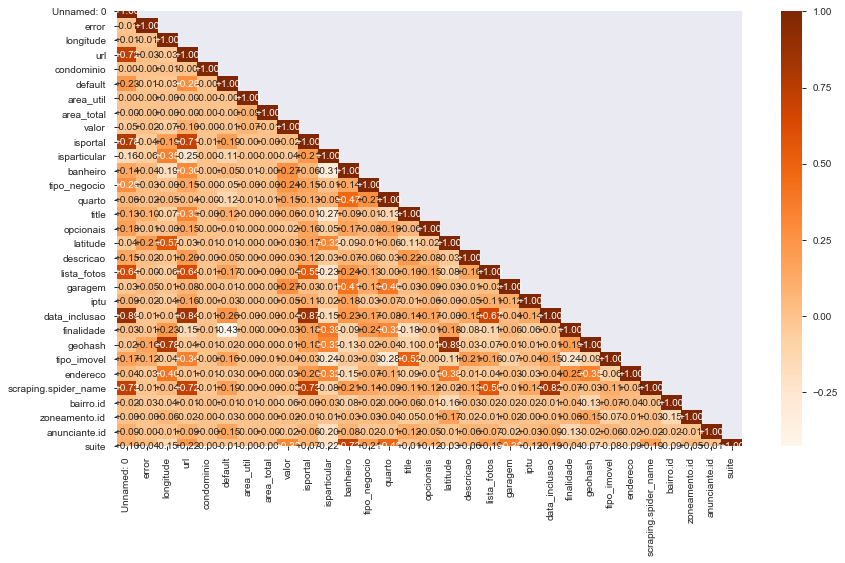

In [12]:
#Heatmap with the correlation of features
plt.subplots(figsize=(14,8))
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True,
                     cmap='Oranges', fmt='+.2f')

Here we can notice some interesting things: There is a strong correlation between "isportal" and "url", "photo list" and "url", "inclusion date" and "url". In addition to a strong correlation between "data inclusion" and "isportal" and "data inclusion" and "scraping spider name". 
Not to mention the expected strong correlation between "suite" and "bathroom" e "latitude", "longitude" e "geohash".

As the features are in different scales, in order to avoid deviations in the analysis, it is ideal to transform all variables to the same scale, which is what was done next.

In [13]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['condominio', 'area_util', 'area_total', 'valor']

features_log_minmax_transform = pd.DataFrame(data = data)
features_log_minmax_transform = scaler.fit_transform(data)

features_log_minmax_transform = pd.DataFrame(data = features_log_minmax_transform, columns=data.columns)
# Show an example of a record with scaling applied
display(features_log_minmax_transform.head())

,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
0,0.000000,0.333333,0.460449,0.185163,0.000009,0.0,0.000017,9.237130e-07,0.000014,0.0,...,0.0,0.666667,0.591823,0.04375,0.242934,0.821782,0.651786,0.265625,0.273359,0.000000
1,0.000007,0.333333,0.442051,0.195768,0.000006,0.0,0.000005,4.865359e-07,0.000011,0.0,...,0.0,0.666667,0.623930,0.86625,0.977159,0.821782,0.705357,0.588542,0.273359,0.000000
2,0.000013,0.333333,0.031795,0.188013,0.000006,0.0,0.000000,0.000000e+00,0.006428,0.0,...,0.0,0.666667,0.225114,0.10000,0.446982,0.821782,0.696429,0.770833,0.273359,0.052632
3,0.000020,0.333333,0.028974,0.188387,0.000010,0.0,0.000000,0.000000e+00,0.014200,0.0,...,0.0,0.666667,0.307499,0.10000,0.211105,0.821782,0.714286,0.312500,0.273359,0.105263
4,0.000027,0.333333,0.835353,0.191443,0.000000,0.0,0.000003,1.621786e-07,0.000006,0.0,...,0.0,0.222222,0.177323,0.55625,0.093185,0.821782,0.544643,0.520833,0.273359,0.000000


___

Just as a curiosity, let's check some points of the coordinates on a real map.

In [14]:
latitudes = latitude[(latitude != 0)]

In [15]:
longitudes = longitude[(longitude != 0)]

In [16]:
coordenadas = []
for i in latitudes.index:
    if (latitudes[i] < -25) & (longitudes[i] < -49):
        coordenadas.append((latitudes[i], longitudes[i]))

In [17]:
coor_sample = random.sample(coordenadas, 500)

In [18]:
mapa = folium.Map(location=[latitude[0], longitude[0]], zoom_start=11)

In [19]:
for i in range(len(coor_sample)):
    folium.Marker(coor_sample[i]).add_to(mapa)

In [20]:
mapa

We can now visually notice that most of the points are contained in the city of Curitiba / Pr.

___

We will use DecisionTreeRegressor to see how easy it would be to predict a given column based on the other columns. The experiment will be verified through an average of 100 runs.

<cite>Buitinck, L., Louppe, G., Blondel, M., Pedregosa, F., Mueller, A., Grisel, O., Niculae, V.,Prettenhofer, P., Gramfort, A., Grobler, J., Layton, R., VanderPlas, J., Joly, A., Holt,B., and Varoquaux, G. (2013). API design for machine learning software: experiencesfrom the scikit-learn project. InECML PKDD Workshop: Languages for Data Miningand Machine Learning, pages 108–122.</cite>

In [23]:
data_no_inclusao = data.drop(columns=['data_inclusao'])

In [24]:
def calculate_r2_for_feature(data,feature):
    new_data = data.drop(feature, axis=1)

    X_train, X_test,y_train, y_test = train_test_split(new_data,data[feature],test_size=0.25)

    regressor = DecisionTreeRegressor(random_state=1)
    regressor.fit(X_train,y_train)

    score = regressor.score(X_test,y_test)
    return score.round(2)

def r2_mean(data,feature,runs=100):
    return np.array([calculate_r2_for_feature(data,feature) 
                     for _ in range(100) ]).mean().round(4)

for column in data_no_inclusao.columns:
    print("{0:17} {1}".format(column, r2_mean(data_no_inclusao,column)))

Unnamed: 0        0.98
error             0.9864
longitude         1.0
url               0.97
condominio        -45.7864
default           0.9582
area_util         -15.4682
area_total        -1450.2914
valor             0.2502
isportal          1.0
isparticular      1.0
banheiro          0.5992
tipo_negocio      0.9988
quarto            0.7025
title             0.7558
opcionais         -0.3753
latitude          1.0
descricao         -0.0152
lista_fotos       0.5131
garagem           0.0199
iptu              -0.2187
finalidade        0.909
geohash           1.0
tipo_imovel       0.8188
endereco          0.7816
scraping.spider_name 1.0
bairro.id         0.7547
zoneamento.id     0.9566
anunciante.id     0.2408
suite             0.6637


We can see that several variables would be easily predictable with the other columns, such as "isportal", "isparticular", "tipo_negocio", "latitude", "url", "default", "purpose", among others.

___

To find outliers we are going to create a bloxplot chart of each of the features.

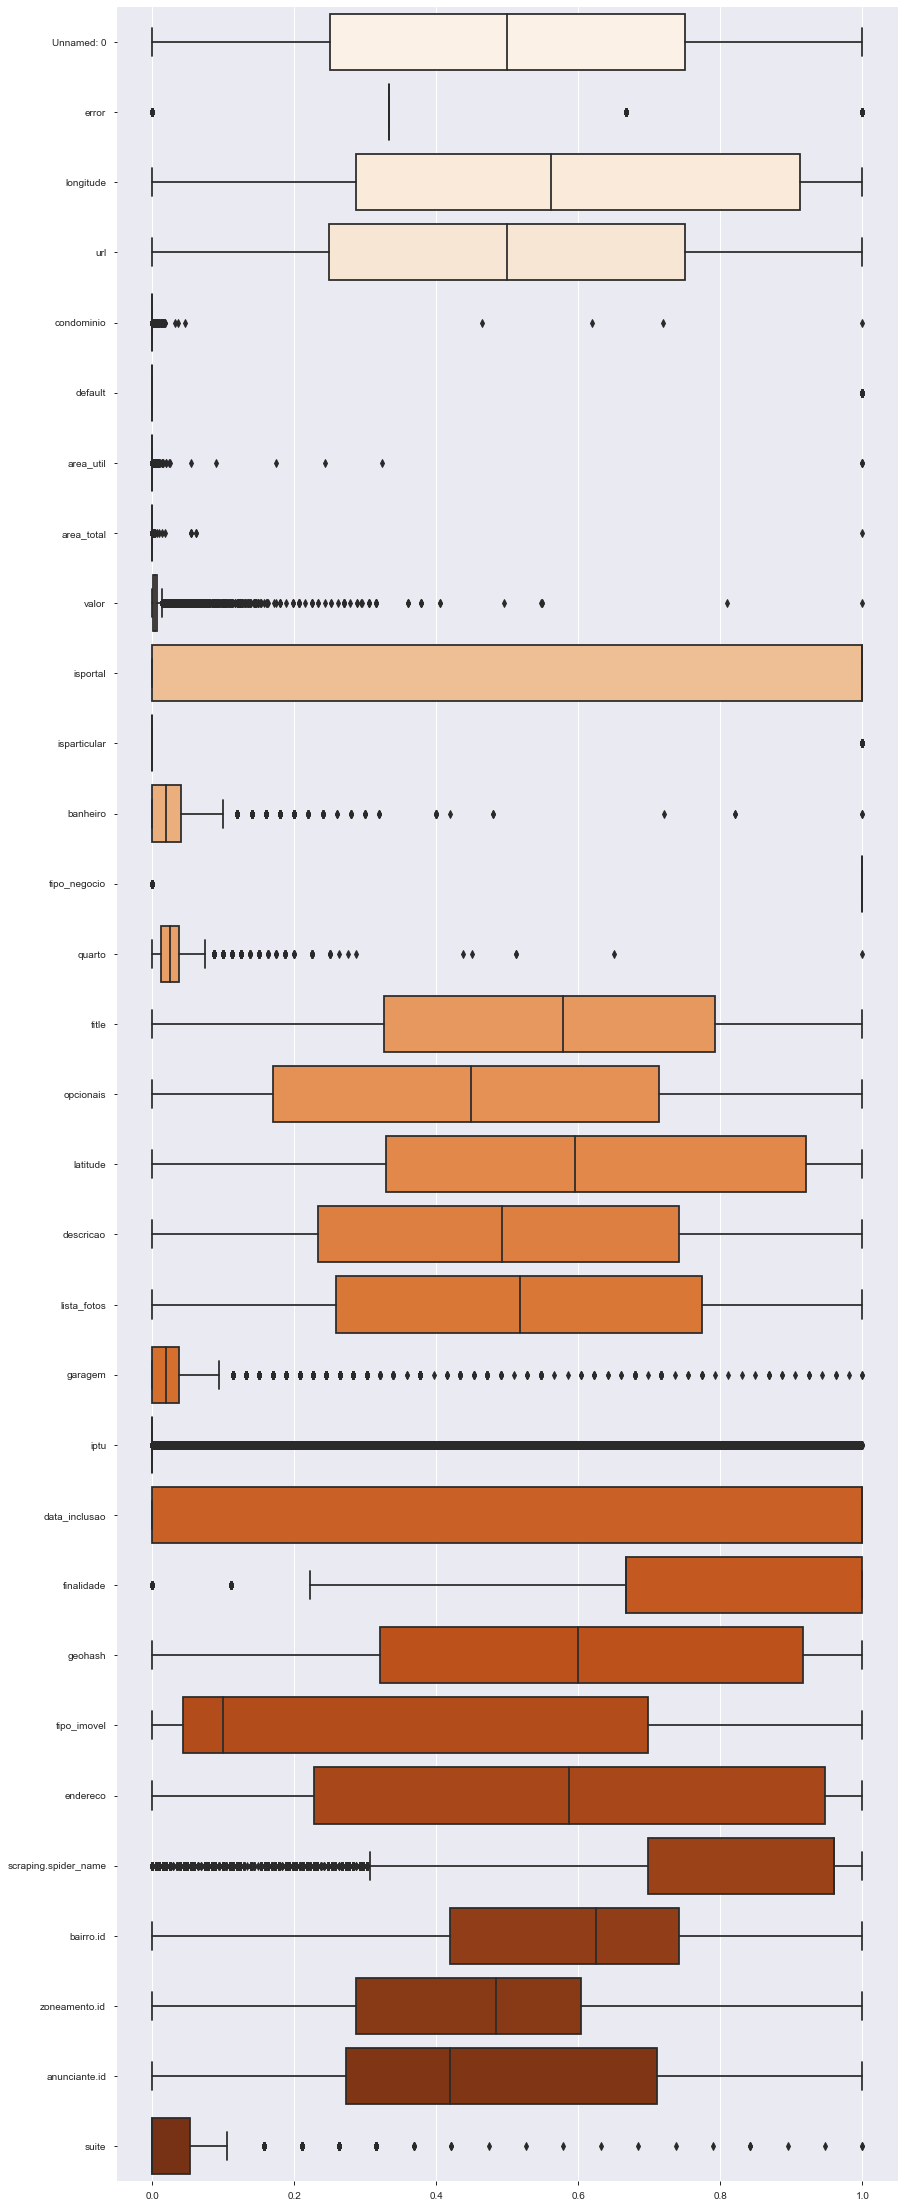

In [25]:
# Boxplot for see the presence of outliers
plt.subplots(figsize=(14,40))
sns.boxplot(data=features_log_minmax_transform, orient='h', palette="Oranges");

In this bloxplot we can see that there are outliers in several columns, such as "valor", "area_total" and others.

Next we will find the outliers for each of the columns, taking into account very small and very large values. Let's create a new dataset by removing the rows that contain more than one column considered outlier.

In [26]:
outliers_multi = []
outliers = []
# For each feature find the data points with extreme high or low values
for feature in features_log_minmax_transform.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(features_log_minmax_transform[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(features_log_minmax_transform[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(features_log_minmax_transform[~((features_log_minmax_transform[feature] >= Q1 - step) & (features_log_minmax_transform[feature] <= Q3 + step))])
    
    feature_outliers=features_log_minmax_transform[~((features_log_minmax_transform[feature] >= Q1 - step) & (features_log_minmax_transform[feature] <= Q3 + step))].index.values    
    outliers_multi.extend(x for x in feature_outliers if (x in outliers) & (x not in outliers_multi))
    outliers.extend(x for x in feature_outliers if x not in outliers)

#print("Data points that appear as outliers in more than one feature = " , outliers_multi)

# Remove the outliers, if any were specified
good_data = features_log_minmax_transform.drop(features_log_minmax_transform.index[outliers_multi]).reset_index(drop = True)

Data points considered outliers for the feature 'Unnamed: 0':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'error':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
9,0.000060,1.0,0.259071,0.191710,0.000001,0.0,0.000005,0.000000e+00,0.000007,0.0,...,0.0,0.222222,0.831487,0.55625,0.625552,0.821782,0.321429,0.484375,0.273359,0.000000
90,0.000600,1.0,0.592660,0.184870,0.000008,0.0,0.000009,7.192269e-07,0.000020,0.0,...,0.0,0.666667,0.680377,0.04375,0.110901,0.821782,0.410714,0.484375,0.273359,0.052632
91,0.000607,1.0,0.627115,0.087196,0.000006,0.0,0.000012,1.353839e-06,0.003231,0.0,...,0.0,0.666667,0.908990,0.04375,0.016936,0.277228,0.660714,0.484375,0.540404,0.052632
98,0.000653,1.0,0.415224,0.369666,0.000000,0.0,0.000000,0.000000e+00,0.005265,0.0,...,0.0,0.666667,0.841462,0.10000,0.109192,0.089109,0.321429,0.484375,0.639520,0.052632
175,0.001167,1.0,0.534776,0.065754,0.000000,0.0,0.000004,1.974348e-07,0.000007,0.0,...,0.0,0.222222,0.690874,0.75875,0.514095,0.232673,0.616071,0.484375,0.330177,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149897,0.999533,1.0,0.475417,0.905676,0.000000,0.0,0.000059,6.064070e-06,0.002691,1.0,...,1.0,0.666667,0.857577,0.99000,0.711123,0.960396,0.830357,0.484375,0.538510,0.000000
149898,0.999540,1.0,0.944968,0.778406,0.000004,0.0,0.000011,6.487145e-07,0.002700,1.0,...,1.0,0.666667,0.997575,0.81375,0.903510,0.960396,0.687500,0.484375,0.648990,0.052632
149911,0.999627,1.0,0.281667,0.550765,0.000005,0.0,0.000008,6.698682e-07,0.002691,1.0,...,1.0,0.666667,0.837932,0.61625,0.027595,0.960396,0.321429,0.484375,0.177399,0.052632
149926,0.999727,1.0,0.685769,0.737858,0.000000,1.0,0.000006,3.384597e-07,0.002691,1.0,...,1.0,0.666667,0.910372,0.74625,0.712869,0.960396,0.660714,0.484375,0.106061,0.000000


Data points considered outliers for the feature 'longitude':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'url':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'condominio':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
18,0.000120,0.333333,0.697083,0.182347,0.000018,0.0,0.000024,1.967297e-06,0.008910,0.0,...,0.0,0.666667,0.781577,0.04375,0.780093,0.821782,0.419643,0.604167,0.273359,0.052632
48,0.000320,0.333333,0.356378,0.189782,0.000024,0.0,0.000030,2.390372e-06,0.000095,0.0,...,0.0,0.222222,0.418583,0.17750,0.092925,0.821782,0.562500,0.588542,0.273359,0.000000
127,0.000847,0.333333,0.460449,0.180712,0.000015,0.0,0.000023,1.233968e-06,0.000023,0.0,...,0.0,0.666667,0.591823,0.04375,0.242934,0.821782,0.651786,0.265625,0.273359,0.052632
130,0.000867,0.333333,0.620897,0.181179,0.000014,0.0,0.000020,1.389095e-06,0.000019,0.0,...,0.0,0.666667,0.755978,0.04375,0.032498,0.821782,0.410714,0.604167,0.273359,0.052632
176,0.001174,0.333333,0.499776,0.183956,0.000015,0.0,0.000019,1.544223e-06,0.009900,0.0,...,0.0,0.666667,0.577703,0.04375,0.470009,0.821782,0.285714,0.250000,0.273359,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149205,0.994919,0.333333,0.435385,0.443916,0.000026,0.0,0.000006,6.346120e-07,0.002610,1.0,...,1.0,0.666667,0.582922,0.04375,0.797400,0.960396,0.651786,0.265625,0.471591,0.052632
149491,0.996826,1.000000,0.210288,0.944376,0.000019,0.0,0.000020,2.171783e-06,0.002682,1.0,...,1.0,1.000000,0.663096,0.99000,0.417939,0.960396,0.866071,0.484375,0.742424,0.000000
149730,0.998420,0.333333,0.471186,0.519140,0.000015,1.0,0.000013,8.461493e-07,0.002700,1.0,...,1.0,0.666667,0.617913,0.03750,0.003343,0.960396,0.651786,0.588542,0.444444,0.052632
149909,0.999613,0.333333,0.096763,0.885189,0.000070,1.0,0.000004,3.948697e-07,0.002700,1.0,...,1.0,0.222222,0.272630,0.79375,0.265627,0.960396,0.383929,0.369792,0.120581,0.000000


Data points considered outliers for the feature 'default':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
141,0.000940,0.333333,0.022051,0.185270,0.000004,1.0,0.000005,3.243572e-07,0.000004,0.0,...,0.0,0.444444,0.187575,0.04375,0.627409,0.821782,0.696429,0.088542,0.273359,0.000000
143,0.000954,0.333333,0.114423,0.397615,0.000005,1.0,0.000007,4.301259e-07,0.001440,0.0,...,0.0,0.444444,0.030081,0.04375,0.094336,0.301980,0.696429,0.359375,0.662879,0.000000
226,0.001507,0.333333,0.038269,0.187726,0.000000,1.0,0.000000,0.000000e+00,0.003060,0.0,...,0.0,0.444444,0.201541,0.10000,0.537159,0.821782,0.696429,0.770833,0.273359,0.052632
231,0.001540,0.333333,0.114423,0.368932,0.000004,1.0,0.000006,3.596135e-07,0.001341,0.0,...,0.0,0.444444,0.030081,0.04375,0.094336,0.089109,0.696429,0.359375,0.639520,0.000000
284,0.001894,0.333333,0.114423,0.368912,0.000003,1.0,0.000005,3.384597e-07,0.001260,0.0,...,0.0,0.444444,0.030081,0.04375,0.094336,0.089109,0.696429,0.359375,0.639520,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149950,0.999887,0.333333,0.354679,0.950876,0.000000,1.0,0.000005,5.711508e-07,0.002745,1.0,...,1.0,0.222222,0.390712,0.79375,0.059610,0.960396,0.339286,0.250000,0.808712,0.000000
149951,0.999893,0.333333,0.121442,0.544980,0.000000,1.0,0.000007,6.487145e-07,0.002708,1.0,...,1.0,0.666667,0.280273,0.40500,0.316955,0.960396,0.383929,0.385417,0.943182,0.105263
149953,0.999907,0.333333,0.338141,0.683068,0.000004,1.0,0.000008,5.993558e-07,0.002723,1.0,...,1.0,0.666667,0.088585,0.03750,0.947038,0.960396,0.910714,0.843750,0.323232,0.052632
149957,0.999933,0.333333,0.412340,0.518779,0.000009,1.0,0.000010,7.756369e-07,0.002718,1.0,...,1.0,0.666667,0.584088,0.03750,0.799294,0.960396,0.562500,0.265625,0.272096,0.000000


Data points considered outliers for the feature 'area_util':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
107,0.000713,0.333333,0.802564,0.083599,0.000000,0.0,0.000247,0.000014,0.067500,0.0,...,0.0,0.666667,0.708493,0.99000,0.055376,0.232673,0.276786,0.203125,0.330177,0.0
125,0.000834,0.333333,0.351538,0.079548,0.000000,0.0,0.000053,0.000005,0.012150,0.0,...,0.0,0.666667,0.669787,0.10000,0.185032,0.232673,0.321429,0.395833,0.330177,0.0
149,0.000994,0.333333,0.626122,0.190883,0.000000,0.0,0.000051,0.000003,0.003420,0.0,...,0.0,0.222222,0.722122,0.56375,0.980316,0.821782,0.651786,0.838542,0.273359,0.0
181,0.001207,0.333333,0.944776,0.080663,0.000000,0.0,0.000051,0.000003,0.011520,0.0,...,0.0,0.222222,0.988397,0.55625,0.040037,0.232673,0.750000,0.973958,0.330177,0.0
204,0.001360,0.333333,0.138333,0.075411,0.000064,0.0,0.000049,0.000004,0.028800,0.0,...,0.0,0.666667,0.284171,0.04375,0.615822,0.232673,0.383929,0.369792,0.330177,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149727,0.998400,0.666667,0.201763,0.941160,0.000005,0.0,0.000039,0.000004,0.002700,1.0,...,1.0,1.000000,0.836152,0.99000,0.603677,0.960396,0.000000,0.484375,0.406566,0.0
149808,0.998940,0.666667,0.201763,0.941153,0.000005,0.0,0.000039,0.000004,0.002700,1.0,...,1.0,1.000000,0.836152,0.99000,0.603677,0.960396,0.000000,0.484375,0.406566,0.0
149809,0.998946,0.333333,0.974647,0.909781,0.000000,0.0,0.000064,0.000004,0.002700,1.0,...,1.0,1.000000,0.984653,0.99000,0.837437,0.960396,0.750000,0.822917,0.929293,0.0
149878,0.999407,0.333333,0.653878,0.915200,0.000000,0.0,0.000051,0.000003,0.002673,1.0,...,1.0,0.666667,0.926026,0.99000,0.960037,0.960396,0.678571,0.515625,0.941919,0.0


Data points considered outliers for the feature 'area_total':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
81,0.000540,0.333333,0.013397,0.197042,0.000009,0.0,0.000000,0.000006,0.005658,0.0,...,0.0,0.666667,0.259646,0.99000,0.460056,0.821782,0.526786,0.177083,0.273359,0.0
82,0.000547,0.333333,0.013397,0.197056,0.000009,0.0,0.000000,0.000006,0.006230,0.0,...,0.0,0.666667,0.259646,0.99000,0.460056,0.821782,0.526786,0.177083,0.273359,0.0
86,0.000573,0.333333,0.013397,0.197049,0.000009,0.0,0.000000,0.000007,0.008394,0.0,...,0.0,0.666667,0.259646,0.99000,0.460056,0.821782,0.526786,0.177083,0.273359,0.0
107,0.000713,0.333333,0.802564,0.083599,0.000000,0.0,0.000247,0.000014,0.067500,0.0,...,0.0,0.666667,0.708493,0.99000,0.055376,0.232673,0.276786,0.203125,0.330177,0.0
117,0.000780,0.333333,0.973846,0.371415,0.000000,0.0,0.000000,0.000004,0.005850,0.0,...,0.0,0.666667,0.976580,0.99000,0.092813,0.089109,0.392857,0.822917,0.639520,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149809,0.998946,0.333333,0.974647,0.909781,0.000000,0.0,0.000064,0.000004,0.002700,1.0,...,1.0,1.000000,0.984653,0.99000,0.837437,0.960396,0.750000,0.822917,0.929293,0.0
149851,0.999226,0.333333,0.276314,0.566562,0.000007,0.0,0.000009,0.000007,0.002691,1.0,...,1.0,0.666667,0.539366,0.04375,0.012999,0.960396,0.607143,0.588542,0.345960,0.0
149875,0.999387,0.333333,0.778750,0.619309,0.000005,0.0,0.000008,0.000009,0.002700,1.0,...,1.0,0.666667,0.874705,0.04375,0.540910,0.960396,0.375000,0.453125,0.770202,0.0
149897,0.999533,1.000000,0.475417,0.905676,0.000000,0.0,0.000059,0.000006,0.002691,1.0,...,1.0,0.666667,0.857577,0.99000,0.711123,0.960396,0.830357,0.484375,0.538510,0.0


Data points considered outliers for the feature 'valor':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
3,0.000020,0.333333,0.028974,0.188387,0.000010,0.0,0.000000,0.000000,0.014200,0.0,...,0.0,0.666667,0.307499,0.10000,0.211105,0.821782,0.714286,0.312500,0.273359,0.105263
10,0.000067,0.333333,0.028974,0.188393,0.000010,0.0,0.000000,0.000000,0.016556,0.0,...,0.0,0.666667,0.307499,0.10000,0.211105,0.821782,0.714286,0.312500,0.273359,0.210526
15,0.000100,0.333333,0.801923,0.187252,0.000000,0.0,0.000000,0.000000,0.018000,0.0,...,0.0,0.666667,0.710212,0.10000,0.077437,0.821782,0.276786,0.838542,0.273359,0.000000
16,0.000107,0.333333,0.844840,0.188207,0.000000,0.0,0.000000,0.000000,0.015120,0.0,...,0.0,0.666667,0.800239,0.10000,0.821133,0.821782,0.348214,0.942708,0.273359,0.157895
19,0.000127,0.333333,0.297115,0.002055,0.000000,0.0,0.000000,0.000001,0.013410,0.0,...,0.0,0.666667,0.538353,0.04375,0.773222,0.415842,0.562500,0.687500,0.303662,0.105263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109221,0.728300,0.333333,0.999776,0.764225,0.000000,1.0,0.000031,0.000002,0.014400,1.0,...,1.0,0.666667,0.999908,0.73625,0.987744,0.960396,0.437500,0.484375,0.607323,0.105263
109222,0.728307,0.333333,0.942179,0.836319,0.000006,0.0,0.000039,0.000000,0.014400,1.0,...,1.0,0.666667,0.940944,0.10000,0.902358,0.960396,0.848214,0.234375,0.446338,0.157895
109223,0.728314,0.333333,0.857500,0.788343,0.000000,1.0,0.000040,0.000003,0.014311,1.0,...,1.0,0.666667,0.473618,0.73625,0.566537,0.960396,0.848214,0.166667,0.963384,0.052632
109224,0.728320,0.333333,0.317276,0.862232,0.000000,0.0,0.000021,0.000002,0.014318,1.0,...,1.0,0.666667,0.559102,0.21375,0.556137,0.960396,0.705357,0.473958,0.768308,0.157895


Data points considered outliers for the feature 'isportal':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'isparticular':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
33887,0.225963,0.333333,0.999776,0.324453,0.000000,0.0,0.000000,0.0,0.000005,1.0,...,0.0,1.000000,0.999908,0.10000,0.987744,0.69802,0.839286,0.484375,0.305556,0.0
33890,0.225983,0.333333,0.073269,0.282016,0.000004,0.0,0.000008,0.0,0.000009,1.0,...,0.0,1.000000,0.222106,0.04375,0.948487,0.69802,0.437500,0.744792,0.305556,0.0
33892,0.225996,0.333333,0.999776,0.227934,0.000000,0.0,0.000009,0.0,0.000006,1.0,...,0.0,1.000000,0.999908,0.04375,0.987744,0.69802,0.839286,0.484375,0.305556,0.0
33898,0.226036,0.333333,0.999776,0.222755,0.000005,0.0,0.000000,0.0,0.000007,1.0,...,0.0,1.000000,0.999908,0.04375,0.987744,0.69802,0.437500,0.484375,0.305556,0.0
33900,0.226050,0.333333,0.999776,0.342985,0.000005,0.0,0.000004,0.0,0.000010,1.0,...,0.0,1.000000,0.999908,0.04375,0.987744,0.69802,0.303571,0.484375,0.305556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65743,0.438383,0.333333,0.999776,0.228081,0.000004,0.0,0.000006,0.0,0.001436,1.0,...,0.5,1.000000,0.999908,0.04375,0.987744,0.69802,0.580357,0.484375,0.305556,0.0
65744,0.438390,0.333333,0.999776,0.276224,0.000000,1.0,0.000006,0.0,0.001170,1.0,...,0.5,0.444444,0.999908,0.04375,0.987744,0.69802,0.696429,0.484375,0.305556,0.0
65750,0.438430,0.333333,0.999776,0.233880,0.000000,1.0,0.000007,0.0,0.001772,1.0,...,0.5,0.444444,0.999908,0.04375,0.987744,0.69802,0.696429,0.484375,0.305556,0.0
65751,0.438436,0.333333,0.999776,0.232245,0.000000,0.0,0.000006,0.0,0.001701,1.0,...,0.5,1.000000,0.999908,0.04375,0.987744,0.69802,0.535714,0.484375,0.305556,0.0


Data points considered outliers for the feature 'banheiro':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
16,0.000107,0.333333,0.844840,0.188207,0.000000,0.0,0.000000,0.000000,0.015120,0.0,...,0.0,0.666667,0.800239,0.10000,0.821133,0.821782,0.348214,0.942708,0.273359,0.157895
48,0.000320,0.333333,0.356378,0.189782,0.000024,0.0,0.000030,0.000002,0.000095,0.0,...,0.0,0.222222,0.418583,0.17750,0.092925,0.821782,0.562500,0.588542,0.273359,0.000000
59,0.000393,0.333333,0.865609,0.140037,0.000000,0.0,0.000000,0.000000,0.053100,0.0,...,0.0,0.666667,0.510114,0.10000,0.106481,0.539604,0.357143,0.234375,0.412247,0.315789
149,0.000994,0.333333,0.626122,0.190883,0.000000,0.0,0.000051,0.000003,0.003420,0.0,...,0.0,0.222222,0.722122,0.56375,0.980316,0.821782,0.651786,0.838542,0.273359,0.000000
247,0.001647,0.333333,0.908526,0.189067,0.000000,0.0,0.000000,0.000000,0.008910,0.0,...,0.0,0.666667,0.490930,0.10000,0.939276,0.821782,0.357143,0.234375,0.273359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126733,0.845073,0.333333,0.715000,0.812347,0.000000,1.0,0.000039,0.000002,0.002970,1.0,...,1.0,0.666667,0.070107,0.90750,0.764568,0.960396,0.580357,0.281250,0.963384,0.210526
126794,0.845479,0.333333,0.999776,0.736583,0.000000,0.0,0.000039,0.000005,0.005400,1.0,...,1.0,0.666667,0.999908,0.10000,0.987744,0.960396,0.544643,0.484375,0.075126,0.000000
128528,0.857042,0.333333,0.579776,0.734574,0.000000,0.0,0.000045,0.000002,0.003420,1.0,...,1.0,0.666667,0.095614,0.04375,0.696045,0.960396,0.741071,0.286458,0.137626,0.000000
130866,0.872632,0.333333,0.279199,0.513234,0.000004,0.0,0.000007,0.000000,0.002970,1.0,...,1.0,0.666667,0.112956,0.04375,0.349489,0.960396,0.625000,0.250000,0.483586,0.052632


Data points considered outliers for the feature 'tipo_negocio':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
0,0.000000,0.333333,0.460449,0.185163,0.000009,0.0,0.000017,9.237130e-07,0.000014,0.0,...,0.0,0.666667,0.591823,0.04375,0.242934,0.821782,0.651786,0.265625,0.273359,0.000000
1,0.000007,0.333333,0.442051,0.195768,0.000006,0.0,0.000005,4.865359e-07,0.000011,0.0,...,0.0,0.666667,0.623930,0.86625,0.977159,0.821782,0.705357,0.588542,0.273359,0.000000
4,0.000027,0.333333,0.835353,0.191443,0.000000,0.0,0.000003,1.621786e-07,0.000006,0.0,...,0.0,0.222222,0.177323,0.55625,0.093185,0.821782,0.544643,0.520833,0.273359,0.000000
7,0.000047,0.333333,0.266122,0.188747,0.000000,0.0,0.000000,0.000000e+00,0.000016,0.0,...,0.0,0.666667,0.101108,0.10000,0.093779,0.821782,0.625000,0.250000,0.273359,0.052632
9,0.000060,1.000000,0.259071,0.191710,0.000001,0.0,0.000005,0.000000e+00,0.000007,0.0,...,0.0,0.222222,0.831487,0.55625,0.625552,0.821782,0.321429,0.484375,0.273359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149963,0.999973,0.333333,0.492308,0.453345,0.000010,0.0,0.000004,0.000000e+00,0.000022,1.0,...,1.0,0.666667,0.590227,0.04375,0.544253,0.960396,0.651786,0.265625,0.445707,0.000000
149964,0.999980,0.333333,0.492308,0.453319,0.000010,0.0,0.000004,0.000000e+00,0.000022,1.0,...,1.0,0.666667,0.590227,0.86625,0.544253,0.960396,0.651786,0.265625,0.445707,0.000000
149965,0.999987,0.333333,0.999776,0.778212,0.000000,1.0,0.000029,3.173060e-06,0.000022,1.0,...,1.0,0.666667,0.999908,0.70250,0.987744,0.960396,0.687500,0.484375,0.746212,0.052632
149966,0.999993,0.333333,0.098397,0.656060,0.000012,0.0,0.000019,1.064738e-06,0.000022,1.0,...,1.0,0.666667,0.273458,0.04375,0.616565,0.960396,0.383929,0.369792,0.361742,0.052632


Data points considered outliers for the feature 'quarto':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
305,0.002034,0.333333,0.652019,0.061143,0.0,0.0,0.000075,0.000004,0.000063,0.0,...,0.0,0.666667,0.724792,0.10000,0.980576,0.232673,0.651786,0.838542,0.330177,0.000000
395,0.002634,0.333333,0.893301,0.080669,0.0,0.0,0.000117,0.000006,0.029700,0.0,...,0.0,0.222222,0.478376,0.55625,0.065404,0.232673,0.848214,0.166667,0.330177,0.000000
1084,0.007228,1.000000,0.998718,0.059348,0.0,0.0,0.000064,0.000004,0.000053,0.0,...,0.0,0.222222,0.999233,0.29625,0.752795,0.232673,0.160714,0.484375,0.330177,0.000000
1348,0.008989,0.333333,0.787885,0.147772,0.0,0.0,0.000000,0.000000,0.011520,0.0,...,0.0,0.666667,0.882593,0.81375,0.093110,0.663366,0.375000,0.453125,0.962753,0.210526
2520,0.016804,0.333333,0.114423,0.405670,0.0,1.0,0.000000,0.000000,0.003150,0.0,...,0.0,0.444444,0.030081,0.81375,0.094336,0.440594,0.696429,0.359375,0.393939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139938,0.933125,0.333333,0.999776,0.812774,0.0,0.0,0.000033,0.000002,0.004050,1.0,...,1.0,0.666667,0.999908,0.10000,0.987744,0.960396,0.714286,0.484375,0.945076,0.000000
139986,0.933445,0.333333,0.999776,0.812881,0.0,0.0,0.000032,0.000000,0.004050,1.0,...,1.0,0.666667,0.999908,0.10000,0.987744,0.960396,0.544643,0.484375,0.075126,0.052632
141339,0.942467,0.333333,0.207692,0.812608,0.0,0.0,0.000021,0.000001,0.003870,1.0,...,1.0,1.000000,0.320912,0.81375,0.099833,0.960396,0.785714,0.661458,0.474116,0.157895
141722,0.945021,0.333333,0.520321,0.812981,0.0,0.0,0.000026,0.000002,0.004050,1.0,...,1.0,0.666667,0.124804,0.10000,0.327725,0.960396,0.741071,0.817708,0.032828,0.000000


Data points considered outliers for the feature 'title':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'opcionais':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'latitude':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'descricao':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'lista_fotos':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'garagem':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
43,0.000287,0.333333,0.191250,0.190709,0.0,0.0,0.000000,0.000000e+00,0.013050,0.0,...,0.0,0.666667,0.245066,0.10000,0.424587,0.821782,0.758929,0.489583,0.273359,0.000000
115,0.000767,0.333333,0.601506,0.371221,0.0,0.0,0.000000,0.000000e+00,0.005175,0.0,...,0.0,0.666667,0.124252,0.81375,0.999406,0.089109,0.741071,0.286458,0.639520,0.052632
212,0.001414,0.333333,0.835353,0.369339,0.0,0.0,0.000000,0.000000e+00,0.008001,0.0,...,0.0,1.000000,0.177323,0.29625,0.093185,0.089109,0.544643,0.520833,0.639520,0.000000
275,0.001834,0.333333,0.780192,0.187519,0.0,0.0,0.000000,0.000000e+00,0.000050,0.0,...,0.0,0.666667,0.771540,0.10000,0.170288,0.821782,0.464286,0.942708,0.273359,0.000000
378,0.002521,1.000000,0.744006,0.187446,0.0,0.0,0.000000,0.000000e+00,0.000027,0.0,...,0.0,0.666667,0.884926,0.10000,0.698867,0.821782,0.375000,0.484375,0.273359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147242,0.981829,0.333333,0.771122,0.737210,0.0,0.0,0.000010,5.640995e-07,0.002617,1.0,...,1.0,0.666667,0.140060,0.10000,0.865515,0.960396,0.901786,0.244792,0.321970,0.000000
147454,0.983243,0.333333,0.999776,0.782937,0.0,0.0,0.000014,1.692299e-06,0.002430,1.0,...,1.0,0.666667,0.999908,0.87500,0.987744,0.960396,0.580357,0.484375,0.681187,0.052632
148481,0.990091,0.333333,0.999776,0.735802,0.0,0.0,0.000039,2.129476e-06,0.002430,1.0,...,1.0,0.666667,0.999908,0.52875,0.987744,0.960396,0.696429,0.484375,0.975379,0.000000
148611,0.990958,0.333333,0.831154,0.530131,0.0,0.0,0.000008,6.134583e-07,0.002520,1.0,...,1.0,0.666667,0.738328,0.04375,0.055636,0.960396,0.276786,0.203125,0.970328,0.000000


Data points considered outliers for the feature 'iptu':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
0,0.000000,0.333333,0.460449,0.185163,0.000009,0.0,0.000017,9.237130e-07,0.000014,0.0,...,0.0,0.666667,0.591823,0.04375,0.242934,0.821782,0.651786,0.265625,0.273359,0.000000
1,0.000007,0.333333,0.442051,0.195768,0.000006,0.0,0.000005,4.865359e-07,0.000011,0.0,...,0.0,0.666667,0.623930,0.86625,0.977159,0.821782,0.705357,0.588542,0.273359,0.000000
4,0.000027,0.333333,0.835353,0.191443,0.000000,0.0,0.000003,1.621786e-07,0.000006,0.0,...,0.0,0.222222,0.177323,0.55625,0.093185,0.821782,0.544643,0.520833,0.273359,0.000000
7,0.000047,0.333333,0.266122,0.188747,0.000000,0.0,0.000000,0.000000e+00,0.000016,0.0,...,0.0,0.666667,0.101108,0.10000,0.093779,0.821782,0.625000,0.250000,0.273359,0.052632
8,0.000053,0.333333,0.467564,0.179491,0.000006,0.0,0.000008,7.333294e-07,0.002340,0.0,...,0.0,0.666667,0.441020,0.04375,1.000000,0.821782,0.339286,0.869792,0.273359,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149962,0.999967,0.333333,0.098558,0.991932,0.000000,0.0,0.000018,9.871742e-07,0.000016,1.0,...,1.0,0.666667,0.815986,0.81375,0.169285,0.960396,0.732143,0.333333,0.123106,0.052632
149963,0.999973,0.333333,0.492308,0.453345,0.000010,0.0,0.000004,0.000000e+00,0.000022,1.0,...,1.0,0.666667,0.590227,0.04375,0.544253,0.960396,0.651786,0.265625,0.445707,0.000000
149964,0.999980,0.333333,0.492308,0.453319,0.000010,0.0,0.000004,0.000000e+00,0.000022,1.0,...,1.0,0.666667,0.590227,0.86625,0.544253,0.960396,0.651786,0.265625,0.445707,0.000000
149965,0.999987,0.333333,0.999776,0.778212,0.000000,1.0,0.000029,3.173060e-06,0.000022,1.0,...,1.0,0.666667,0.999908,0.70250,0.987744,0.960396,0.687500,0.484375,0.746212,0.052632


Data points considered outliers for the feature 'data_inclusao':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'finalidade':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
15314,0.102116,0.333333,0.075192,0.131882,0.0,1.0,0.000000,3.716922e-06,0.000068,0.0,...,0.0,0.000000,0.032260,0.54500,0.270084,0.500000,0.696429,0.260417,0.666667,0.0
34494,0.230011,0.333333,0.924455,0.037979,0.0,1.0,0.000000,5.182665e-06,0.007560,0.0,...,0.0,0.000000,0.160103,0.29625,0.234912,0.123762,0.544643,0.239583,0.837753,0.0
35764,0.238479,0.333333,0.022468,0.048330,0.0,1.0,0.000000,0.000000e+00,0.000006,0.0,...,0.0,0.000000,0.187329,0.79375,0.302544,0.168317,0.696429,0.088542,0.684975,0.0
35996,0.240026,0.333333,0.024423,0.037832,0.0,1.0,0.000000,6.106378e-06,0.000044,0.0,...,0.0,0.000000,0.194696,0.29625,0.447131,0.123762,0.696429,0.770833,0.837753,0.0
37888,0.252642,0.333333,0.111314,0.148419,0.0,1.0,0.000028,0.000000e+00,0.000019,0.0,...,0.0,0.000000,0.032659,0.79375,0.266667,0.712871,0.696429,0.359375,0.411616,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146020,0.973681,0.333333,0.488974,0.970536,0.0,1.0,0.000005,4.442284e-07,0.002484,1.0,...,1.0,0.111111,0.589766,0.74625,0.297939,0.960396,0.651786,0.265625,0.431187,0.0
147401,0.982890,0.333333,0.999776,0.904956,0.0,1.0,0.000013,1.466659e-06,0.002385,1.0,...,1.0,0.111111,0.999908,0.96750,0.987744,0.960396,0.919643,0.484375,0.075126,0.0
147618,0.984337,0.333333,0.044808,0.761942,0.0,1.0,0.000013,1.410249e-06,0.002520,1.0,...,1.0,0.111111,0.032076,0.70250,0.035023,0.960396,0.696429,0.463542,0.415404,0.0
148612,0.990965,0.333333,0.976474,0.909741,0.0,1.0,0.000064,3.525622e-06,0.002520,1.0,...,1.0,0.111111,0.977163,0.03625,0.087131,0.960396,0.392857,0.822917,0.200126,0.0


Data points considered outliers for the feature 'geohash':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'tipo_imovel':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'endereco':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'scraping.spider_name':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
11,0.000073,0.333333,0.349359,0.064133,0.000000,0.0,0.000006,3.525622e-07,0.000012,0.0,...,0.0,0.222222,0.388932,0.75875,0.059981,0.232673,0.339286,0.250000,0.330177,0.000000
13,0.000087,0.333333,0.746122,0.080062,0.000000,0.0,0.000026,1.421531e-06,0.005220,0.0,...,0.0,0.666667,0.703030,0.10000,0.321486,0.232673,0.517857,0.531250,0.330177,0.000000
14,0.000093,0.333333,0.768462,0.086936,0.000002,0.0,0.000008,4.230747e-07,0.002331,0.0,...,0.0,0.666667,0.873293,0.04375,0.973668,0.277228,0.375000,0.583333,0.540404,0.052632
21,0.000140,0.333333,0.207083,0.087123,0.000004,0.0,0.000007,5.006383e-07,0.003105,0.0,...,0.0,0.666667,0.098192,0.04375,0.470826,0.277228,0.625000,0.343750,0.540404,0.052632
27,0.000180,0.333333,0.437628,0.074183,0.000012,0.0,0.000016,1.589139e-06,0.005310,0.0,...,0.0,0.666667,0.571165,0.04375,0.226964,0.232673,0.339286,0.250000,0.330177,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52472,0.349890,0.333333,0.212660,0.088437,0.000006,0.0,0.000008,6.346120e-07,0.000011,0.0,...,0.0,0.666667,0.544031,0.04375,0.557289,0.297030,0.607143,0.380208,0.803662,0.052632
52473,0.349897,0.333333,0.061282,0.088878,0.000009,1.0,0.000014,1.438454e-06,0.006210,0.0,...,0.0,0.666667,0.266491,0.04375,0.865255,0.297030,0.437500,0.156250,0.803662,0.052632
52474,0.349904,0.333333,0.576603,0.088985,0.000005,1.0,0.000010,7.552588e-07,0.000000,0.0,...,0.0,0.666667,0.454342,0.04375,0.174039,0.297030,0.285714,0.869792,0.803662,0.000000
52475,0.349910,0.333333,0.361186,0.089699,0.000000,0.0,0.000048,2.630114e-06,0.000050,0.0,...,0.0,0.222222,0.403235,0.79375,0.063287,0.297030,0.339286,0.250000,0.803662,0.000000


Data points considered outliers for the feature 'bairro.id':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'zoneamento.id':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'anunciante.id':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite


Data points considered outliers for the feature 'suite':


,Unnamed: 0,error,longitude,url,condominio,default,area_util,area_total,valor,isportal,...,data_inclusao,finalidade,geohash,tipo_imovel,endereco,scraping.spider_name,bairro.id,zoneamento.id,anunciante.id,suite
10,0.000067,0.333333,0.028974,0.188393,0.000010,0.0,0.000000,0.000000e+00,0.016556,0.0,...,0.0,0.666667,0.307499,0.10000,0.211105,0.821782,0.714286,0.312500,0.273359,0.210526
16,0.000107,0.333333,0.844840,0.188207,0.000000,0.0,0.000000,0.000000e+00,0.015120,0.0,...,0.0,0.666667,0.800239,0.10000,0.821133,0.821782,0.348214,0.942708,0.273359,0.157895
31,0.000207,0.333333,0.963365,0.188520,0.000010,0.0,0.000000,0.000000e+00,0.014850,0.0,...,0.0,0.666667,0.933976,0.10000,0.208022,0.821782,0.848214,0.234375,0.273359,0.157895
59,0.000393,0.333333,0.865609,0.140037,0.000000,0.0,0.000000,0.000000e+00,0.053100,0.0,...,0.0,0.666667,0.510114,0.10000,0.106481,0.539604,0.357143,0.234375,0.412247,0.315789
64,0.000427,0.333333,0.737564,0.191063,0.000000,0.0,0.000015,8.461493e-07,0.008123,0.0,...,0.0,0.666667,0.734062,0.04375,0.014188,0.821782,0.508929,0.942708,0.273359,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144124,0.961038,1.000000,0.662051,0.819335,0.000007,1.0,0.000014,8.602518e-07,0.004050,1.0,...,1.0,0.666667,0.876147,0.73625,0.210399,0.960396,0.375000,0.484375,0.508207,0.157895
144225,0.961712,0.333333,0.999776,0.821143,0.000000,0.0,0.000019,9.378155e-07,0.004185,1.0,...,1.0,0.666667,0.999908,0.99875,0.987744,0.960396,0.544643,0.484375,0.794823,0.157895
144269,0.962005,0.333333,0.796314,0.825241,0.000000,0.0,0.000015,8.390981e-07,0.004221,1.0,...,1.0,0.666667,0.496332,0.81375,0.927614,0.960396,0.767857,0.166667,0.027778,0.157895
145372,0.969360,0.333333,0.999776,0.759927,0.000002,0.0,0.000020,1.085892e-06,0.002403,1.0,...,1.0,0.666667,0.999908,0.10000,0.987744,0.960396,0.544643,0.484375,0.092803,0.157895


We can see that the outliers correspond to approximately 1/3 of the total data. In this case, we will remove them, but there would still be room for some studies here.

___

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [27]:
def pca_results_chart(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (18,15))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

The cumulative variance: 


Dimension 1    0.2995
Dimension 2    0.4731
Dimension 3    0.5541
Dimension 4    0.6117
Dimension 5    0.6607
Dimension 6    0.7057
Name: Explained Variance, dtype: float64

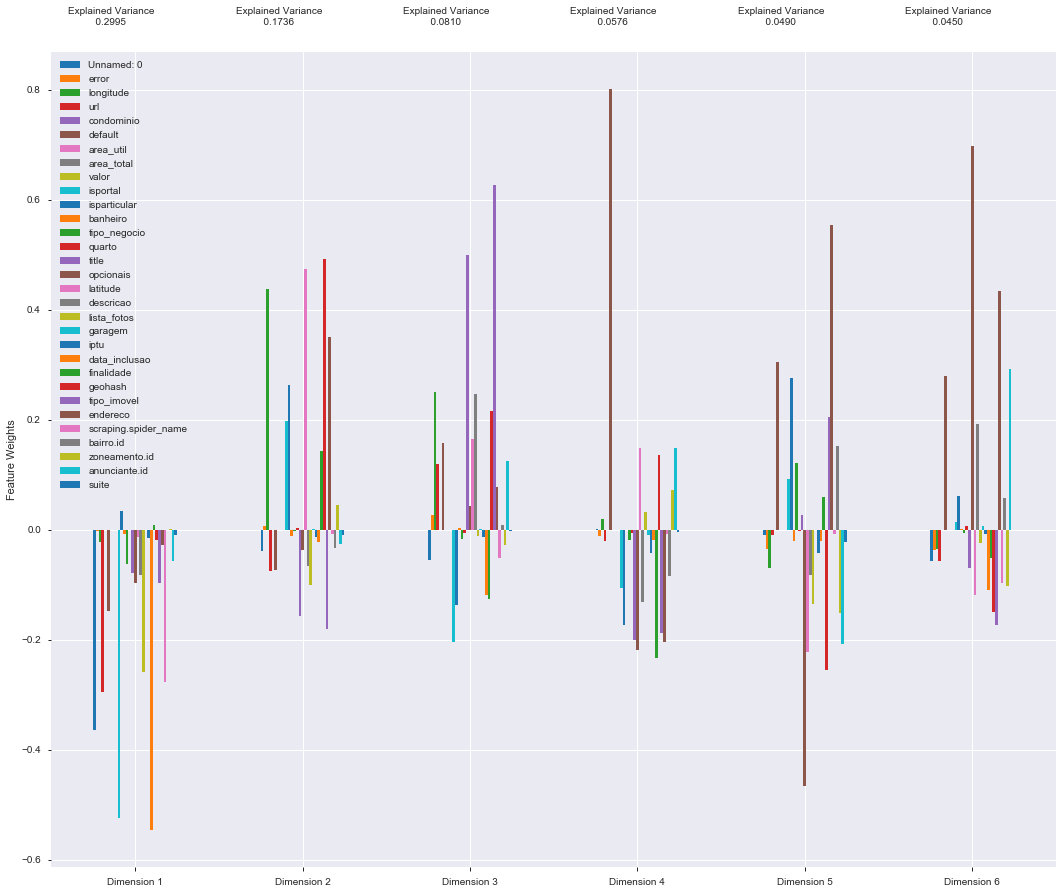

In [28]:
#Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=int(len(good_data.keys())/5), random_state=1).fit(good_data)

samples = data.sample(200)

#Transform log_samples using the PCA fit above
pca_samples = pca.transform(samples)

# Generate PCA results plot
pca_results = pca_results_chart(good_data, pca)

print("The cumulative variance: ")
display(pca_results['Explained Variance'].cumsum())

Here we can see that six dimensions correspond to an accumulated variance of approximately 70%. The first two dimensions correspond to approximately 40% of the data variance.

___

In [29]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

sample_pca = pca.transform(samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [30]:

def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (20,14))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='gray', edgecolors='gray', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 2.0, 1.8,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.05, head_length=0.05, linewidth=2, color='orange')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=18)
    ax.set_ylabel("Dimension 2", fontsize=18)
    ax.set_title("PC plane with original feature projections.", fontsize=25);
    return ax

A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case Dimension 1 and Dimension 2). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

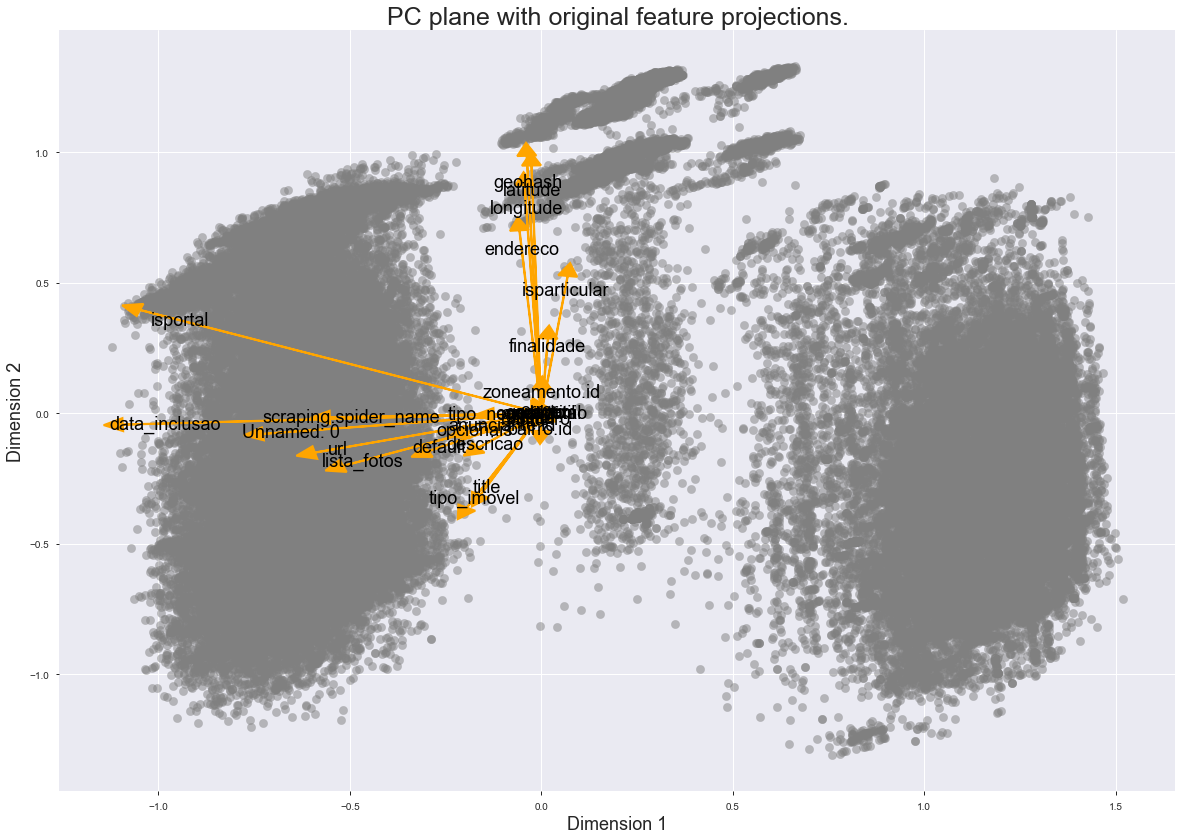

In [31]:
biplot(good_data, reduced_data, pca);

___

In [ ]:
# Apply your clustering algorithm of choice to the reduced data 

def cluster_GMM(num_clusters):
    clusterer = GaussianMixture(n_components = num_clusters, random_state = 1).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    # Find the cluster centers
    centers = clusterer.means_
    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(sample_pca)
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, random_state=1)
    sample_proba = clusterer.predict_proba(sample_pca)
    
    return score, preds, centers, sample_preds, sample_proba

def cluster_Kmeans(num_clusters):
    clusterer = KMeans(n_clusters=num_clusters, random_state = 1).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    # Find the cluster centers
    centers = clusterer.cluster_centers_
    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(sample_pca)
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, random_state=1)
    
    return score, preds, centers, sample_preds

for num_clusters in range(2,7):
    score, preds, _, _, _ = cluster_GMM(num_clusters)
    print("GMM num_clusters: {} - score: {}".format(num_clusters, score))
    
print("\n")

for num_clusters in range(2,7):
    score, preds, _, _ = cluster_Kmeans(num_clusters)
    print("K-Means num_clusters: {} - score: {}".format(num_clusters, score))

GMM num_clusters: 2 - score: 0.5622303731430986
GMM num_clusters: 3 - score: 0.589779752644308
GMM num_clusters: 4 - score: 0.578024118570734
GMM num_clusters: 5 - score: 0.5275691558114938


In [ ]:
def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''

    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("newdataset.csv")
    except:
        print("Dataset could not be loaded. Is the file missing?")       
        return False

    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)
    
    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
        
    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

In [ ]:
channel_results(reduced_data, outliers_multi, sample_pca)

In [ ]:
_, preds, centers, sample_preds = cluster_Kmeans(2)

In [ ]:
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

In [ ]:
# Display the results of the clustering from implementation
cluster_results(reduced_data, preds, centers, sample_pca)

## Conclusion

Therefore, there are still several analyzes that could be performed to improve the understanding of the data, such as the t-sne which is a probabilistic model of clustering for the data. However, despite this, it was possible to reach the conclusion that the data were mined incompletely, and this may have impaired the analysis performed. In addition, analysis could have been performed on text features such as description and address using word2vec to further improve the understanding of the data.